In [36]:
import pandas as pd
from scipy.stats import norm
import numpy as np
import plotly.graph_objs as go
import plotly.express as px
import pystable

In [37]:
from IPython.display import Image
interact_chart = False

# Get Data

In [38]:
bayc = pd.read_csv('risk_pipeline/outputs/data/BAYC_1622485800_1677609000_3600_secs_treated.csv', index_col=0)
bayc.time = pd.to_datetime(bayc.time)
bayc

,time,close
0,2022-04-18 18:00:00+00:00,108.000000
1,2022-04-18 19:00:00+00:00,108.000000
2,2022-04-18 20:00:00+00:00,108.000000
3,2022-04-18 21:00:00+00:00,108.000000
4,2022-04-18 22:00:00+00:00,108.000000
...,...,...
7580,2023-02-28 14:00:00+00:00,72.000000
7581,2023-02-28 15:00:00+00:00,71.640000
7582,2023-02-28 16:00:00+00:00,71.375000
7583,2023-02-28 17:00:00+00:00,70.990000


# Analysis

In [39]:
def line_chart(df, title, xcol, ycol, x_title, y_title):
    fig = px.line(df, x=xcol, y=ycol)
    fig.update_layout(title=title)
    fig.update_layout(xaxis_title=x_title, yaxis_title=y_title)
    return fig

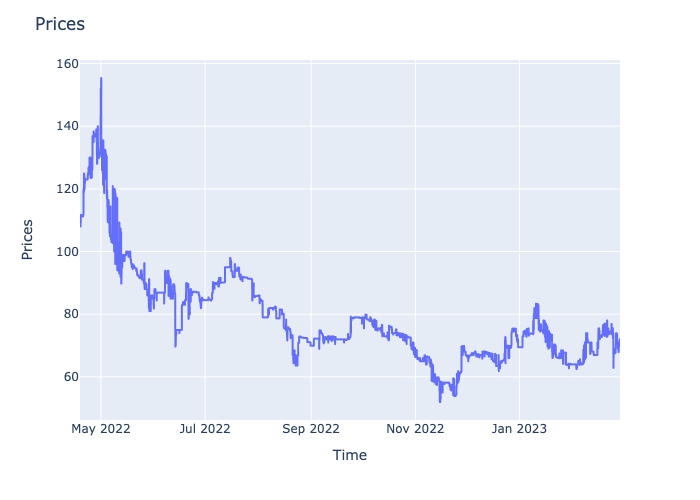

In [40]:
plt = line_chart(bayc, 'Prices', 'time', 'close', 'Time', 'Prices')
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [41]:
# Pystable funcs

def gaussian():
    return pystable.create(alpha=2.0, beta=0.0, mu=0.0,
                           sigma=1.0, parameterization=1)

def get_qs(dst):
    l = [i/100 for i in range(1, 100, 1)]
    return pystable.q(dst, l, len(l))

def pdf(dst, vals):
    return pystable.pdf(dst, vals, len(vals))

def log_returns(p):
    return [np.log(p[i]/p[i-1]) for i in range(1, len(p))]


# Data funcs
def get_qs_data(series):
    l = [i for i in range(1, 100, 1)]
    return [np.percentile(series, i) for i in l]

def set_periodicity(df, time_col, price_col, tf):
    df.index = df[time_col]
    df = df[[price_col]]
    df = df.resample(f"{tf}S").ohlc()
    df = df[price_col][[price_col]]
    df.reset_index(inplace=True)
    df.close.ffill(inplace=True)
    return df


def twap(df, time_col, price_col, tf):
    df.set_index(time_col, inplace=True)
    df = df[[price_col]]
    df = df.rolling(f'{tf}s', min_periods=1).mean()
    df.reset_index(inplace=True)
    return df

def change_interval(df, time_col, price_col, tf):
    df = df.copy(deep=True)
    df = twap(df, time_col, price_col, tf)
    df = set_periodicity(df, time_col, price_col, tf)
    return df


In [42]:
# Get multiple dfs with different 6, 12, 18, ... hour time intervals
dfs = []
step_rng = range(6*3600, 2*86400, 6*3600)
for i in step_rng:
    dfs.append(change_interval(bayc, 'time', 'close', i))

In [43]:
# Get log returns for each df
lrs = []
for i in range(len(dfs)):
    lrs.append(log_returns(dfs[i].close))

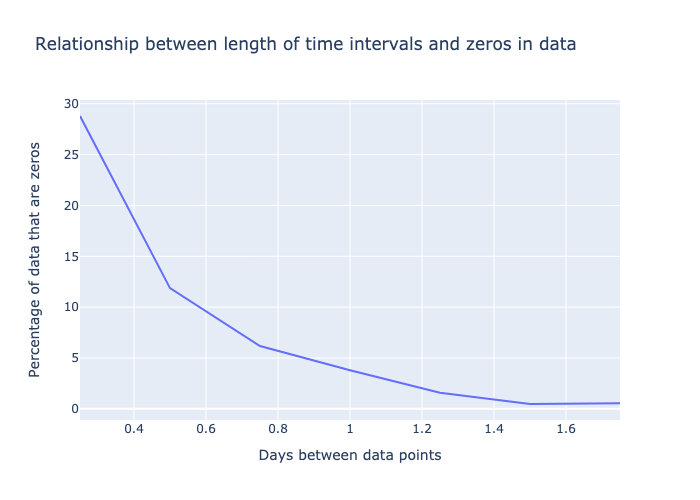

In [44]:
# Count the number of zeros in each sublist of log returns
zero_counts = [(sublist.count(0)/len(sublist))*100 for sublist in lrs]

plt = px.line(
    x=[i/86400 for i in list(step_rng)],
    y=zero_counts,
    labels={'x': 'Days between data points', 'y': 'Percentage of data that are zeros'},
    title='Relationship between length of time intervals and zeros in data'
)
plt.show() if interact_chart else Image(plt.to_image(format="png"))

In [45]:
# Get init gaussian dists
dsts = []
for i in range(len(step_rng)):
    dsts.append(gaussian())

# Fit stable dists
for i in range(len(step_rng)):
    pystable.fit(dsts[i], lrs[i], len(lrs[i]))

# Get ranges
dist_range = []
for i in range(len(step_rng)):
    qs = get_qs(dsts[i])
    dist_range.append(
        qs[-1] - qs[0]
    )

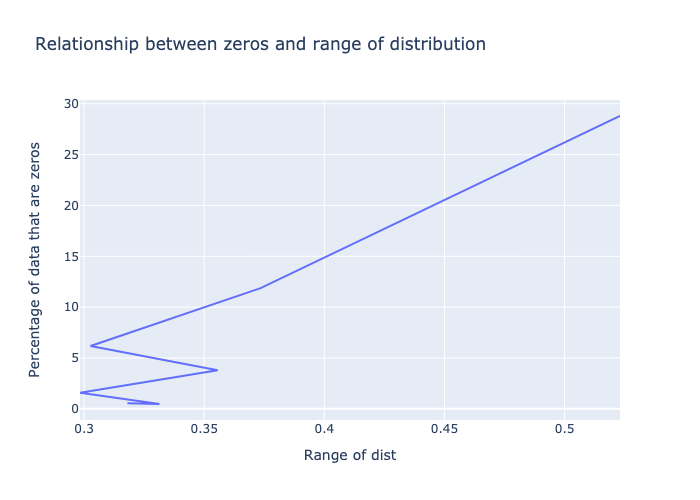

In [46]:
plt = px.line(
    x=dist_range,
    y=zero_counts,
    labels={'x': 'Range of dist', 'y': 'Percentage of data that are zeros'},
    title='Relationship between zeros and range of distribution'
)
plt.show() if interact_chart else Image(plt.to_image(format="png"))